# Compute TD gated likelihood

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from tqdm import tqdm
from numpy.fft import rfft, irfft
from scipy.linalg import circulant, toeplitz

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import ESAOrbits, EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral
from few.utils.utility import get_p_at_t
from few.utils.fdutils import *
traj_module = EMRIInspiral(func="KerrEccEqFlux")

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State
from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from eryn.backends import HDFBackend

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
#Tobs = 1  # [years]
#dt = 50.0  # [s]

Tobs = 0.006 # almost 2 days [yrs]
dt = 10.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
#p0 = 8.2  # initial semi-latus rectum
p0 = 5.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        #t0 = 10000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

Generate TD data with detector response

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=False,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

#### Generate TD waveform

In [8]:
# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 10.29 s


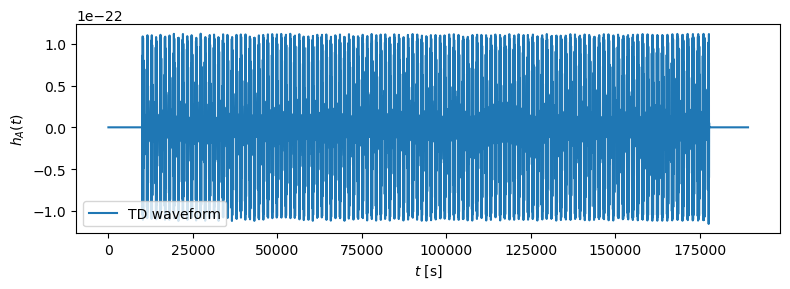

In [9]:
# Visualise the signal
time_array = np.arange(0,len(chans[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans[0], label='TD waveform')
plt.ylabel(r'$h_{A}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(1.7e5,1.9e5)
plt.legend()
plt.tight_layout()

plt.show()

#### Define w and W (gated function)

Choose positions of gaps: at 20%, 40%... of signal

In [10]:
N_d = 2*int(60*60/dt)   # Length gap: 2 hrs
#N_d = 2*int(60*60*24/dt)  # Length gap: 2 day

N_tot = len(chans[0])   # Tot lenght of signal

u = np.array([0.20, 0.40, 0.60, 0.80])  # position of gaps (after 20%, 40%... of signal)

idx = np.floor(u * (N_tot - N_d) - 1).astype(int) # obtain the indeces of such positions

Create w as an array of ones, where I put to zero the entries that correspond to the gaps

In [11]:
w = np.ones(N_tot, dtype=int)  
for i in idx: w[i:i+N_d] = 0     

Dataset with gaps obtained by multiplying the waveform by w (which sets the gap portions of the signal to zero)

In [12]:
chans_gap = chans * w

W diagonal matrix with w as its diagonal

In [13]:
W = np.diag(w)

Visualise signal with gaps

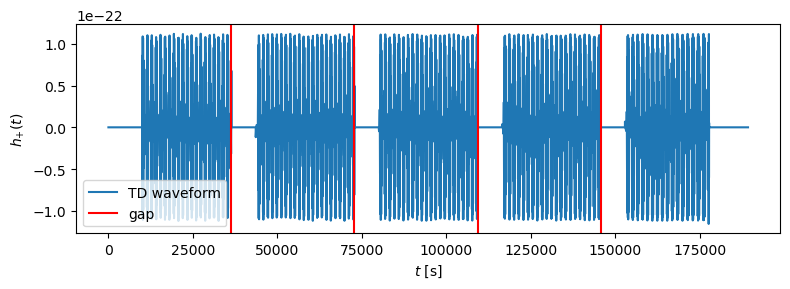

In [14]:
time_array = np.arange(0,len(chans_gap[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans_gap[0], label='TD waveform')
plt.axvline(idx[0]*dt, color='r', label='gap')
plt.axvline(idx[1]*dt, color='r')
plt.axvline(idx[2]*dt, color='r')
plt.axvline(idx[3]*dt, color='r')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()

# TD likelihood 

### Compute gated covariance in TD

I'm doing everything for one channel (A). If it works, then I'll add also the second channel in the computation of the likelihood.

First, I compute the gated covariance matrix $(W \Sigma W)$ in TD for a Toeplitz process, as presented in Burke+(2025) paper.

In [15]:
def build_toeplitz_gated_sigma(psd_positive, w):
    """
    Builds the toeplitz matrix from PSD sampled at positive frequencies only.
    
    Args:
        psd_positive: PSD samples at positive frequencies (length N+1 from rfftfreq(2*N))
        w: gating mask (length N)
    
    Returns:
        C: Gated Toeplitz covariance matrix
    """
    N = len(w)
    
    # autocovariance
    acov_full = np.fft.irfft(psd_positive, n=2*N)
    
    # Take first N values
    acov = acov_full[:N]
    
    # Build Toeplitz
    C = toeplitz(acov)
    
    # Apply gating
    if w is not None:
        if w.shape[0] != N: raise ValueError("w must have length N")
        mask = (w == 0)
        C[mask, :] = 0
        C[:, mask] = 0
    
    return C

In [16]:
# Sample the psd and build toeplitz gated sigma
N = len(chans[0])
freqs_2N_pos = np.fft.rfftfreq(2*N+1, d=dt)
Sn_2N = get_sensitivity(freqs_2N_pos, sens_fn="A1TDISens")

Sigma = build_toeplitz_gated_sigma(Sn_2N, w)

/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:633: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:635: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:637: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:642: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/opt/anaconda3/envs/thesis/lib/python3.12/site-packages/lisatools/detector.py:644: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [17]:
print(Sigma)

[[264075.20861941 264075.20861941 264075.20861941 ... 264075.20861941
  264075.20861941 264075.20861941]
 [264075.20861941 264075.20861941 264075.20861941 ... 264075.20861941
  264075.20861941 264075.20861941]
 [264075.20861941 264075.20861941 264075.20861941 ... 264075.20861942
  264075.20861941 264075.20861941]
 ...
 [264075.20861941 264075.20861941 264075.20861942 ... 264075.20861941
  264075.20861941 264075.20861941]
 [264075.20861941 264075.20861941 264075.20861941 ... 264075.20861941
  264075.20861941 264075.20861941]
 [264075.20861941 264075.20861941 264075.20861941 ... 264075.20861941
  264075.20861941 264075.20861941]]


### Invert each bloch

In [18]:
def identify_data_segments(w):
    # Return a list (start, end) for each segment where w==1
    segments = []
    in_seg = False
    start = None
    for i, v in enumerate(w):
        if v and not in_seg:
            start = i
            in_seg = True
        elif (not v) and in_seg:
            segments.append((start, i))
            in_seg = False
    if in_seg:
        segments.append((start, len(w)))
    return segments

In [19]:
def blockwise_pinv_all_blocks(Sigma, w, symmetrize_output=True, verbose=True):
    """
    Compute pseudoinverse of every block of Sigma.
    For i<=j compute pinv(A_ij), store it and mirror to (j,i) using transpose, ensuring M is symmetric.
    """
    
    N = Sigma.shape[0]
    assert Sigma.shape == (N, N), "Sigma must be square"
    w = np.asarray(w).astype(bool)

    segments = identify_data_segments(w)

    # Check symmetry on input
    if not np.allclose(Sigma, Sigma.T, atol=1e-12, rtol=1e-14):
        print("Input Sigma not exactly symmetric")

    # Prepare index arrays per segment
    idx_list = [np.arange(s, e) for (s, e) in segments]
    sizes = [len(idx) for idx in idx_list]
    if verbose:
        total_pts = sum(sizes)
        print(f"Found {len(segments)} segments, total data points = {total_pts} / {N}")
        print("Segment sizes:", sizes)

    M = np.zeros_like(Sigma, dtype=float) # full matrix

    # iterate over upper triangle i<=j
    for i in range(len(segments)):
        idx_i = idx_list[i]
        m_i = sizes[i]
        for j in range(i, len(segments)):
            idx_j = idx_list[j]
            m_j = sizes[j]
            A_ij = Sigma[np.ix_(idx_i, idx_j)] # extract block A_ij (shape m_i x m_j)
            if verbose:
                print(f"Computing pinv for block ({i},{j}) with shape {A_ij.shape} ...", end=' ')
            
            # compute pseudoinverse of A_ij
            pinv_A_ij = np.linalg.pinv(A_ij)
            M[np.ix_(idx_i, idx_j)] = pinv_A_ij.T
            M[np.ix_(idx_j, idx_i)] = pinv_A_ij
            if verbose:
                print("done.")

    if verbose:
        print("Blockwise pseudoinverse computed.")
    return M

Compute the pseudoinverse.

In [20]:
pinv_computation = True

pinv_filename = "pinv_Sigma_gated.npy"

if pinv_computation:
    # Compute pseudoinverse
    start = time.time()
    pinv_Sigma_gated = blockwise_pinv_all_blocks(Sigma, w, verbose=True)
    print(f"Pseudoinverse computation took {time.time()-start:.2f} s")
    
    # Save result
    np.save(pinv_filename, pinv_Sigma_gated)
    print(f"Pseudoinverse saved to {pinv_filename}")
else:
    # Load pseudoinverse from file
    print(f"Loading pseudoinverse from {pinv_filename}")
    pinv_Sigma_gated = np.load(pinv_filename)
    print(f"Pseudoinverse loaded successfully")

Found 5 segments, total data points = 16054 / 18934
Segment sizes: [3641, 2923, 2923, 2923, 3644]
Computing pinv for block (0,0) with shape (3641, 3641) ... done.
Computing pinv for block (0,1) with shape (3641, 2923) ... done.
Computing pinv for block (0,2) with shape (3641, 2923) ... done.
Computing pinv for block (0,3) with shape (3641, 2923) ... done.
Computing pinv for block (0,4) with shape (3641, 3644) ... done.
Computing pinv for block (1,1) with shape (2923, 2923) ... done.
Computing pinv for block (1,2) with shape (2923, 2923) ... done.
Computing pinv for block (1,3) with shape (2923, 2923) ... done.
Computing pinv for block (1,4) with shape (2923, 3644) ... done.
Computing pinv for block (2,2) with shape (2923, 2923) ... done.
Computing pinv for block (2,3) with shape (2923, 2923) ... done.
Computing pinv for block (2,4) with shape (2923, 3644) ... done.
Computing pinv for block (3,3) with shape (2923, 2923) ... done.
Computing pinv for block (3,4) with shape (2923, 3644) ..

### Compute the likelihood

Signal

In [21]:
def signal_gen(*emri_waveform_args):
    return fastlisaresponse(*emri_waveform_args, emri_waveform_kwargs=emri_waveform_kwargs)

Residual

In [22]:
def residual_computation(d, W, h):
    gated_data = W @ d
    return gated_data - h

Likelihood

In [23]:
def log_likelihood(d, *emri_waveform_args, pinv_Sigma=pinv_Sigma_gated):
    """
    Compute the gated log-likelihood presented in Eq.40 of Burke+(2025) paper.
    where `h` is produced by `signal_gen(*emri_waveform_args)`.

    Args:
        d: Observed data. 
        *emri_waveform_args: Arguments passed directly to `signal_gen` in order to 
            generate the waveform model `h(theta)`.
        pinv_Sigma: pseudoinverse of TD gated covariance matrix.

    Returns:
        float or complex: Value of the log-likelihood. Returns a real scalar by
            default, or complex if `complex=True` is passed in `inner_kwargs`.
    """
    
    h = signal_gen(*emri_waveform_args)

    r = residual_computation(d[0], W, h[0])

    prod = r.T @ pinv_Sigma @ r

    return -0.5 * prod

Quick

In [24]:
log_likelihood(chans, *emri_waveform_args)

np.float64(-0.0)

### Evaluate the likelihood behaviour to check

In [25]:
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
p0 = 5.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

In [26]:
M_grid = np.linspace(9e5, 1.1e6, 11)

direct_logL = -1 * np.ones(len(M_grid))
lisatools_logL = -1 * np.ones(len(M_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)

for idx, M in tqdm(enumerate(M_grid), total=len(M_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    
    direct_logL[idx] = log_likelihood(chans, *emri_waveform_args_M)


python(13611) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
M grid: 100%|█████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.96s/it]


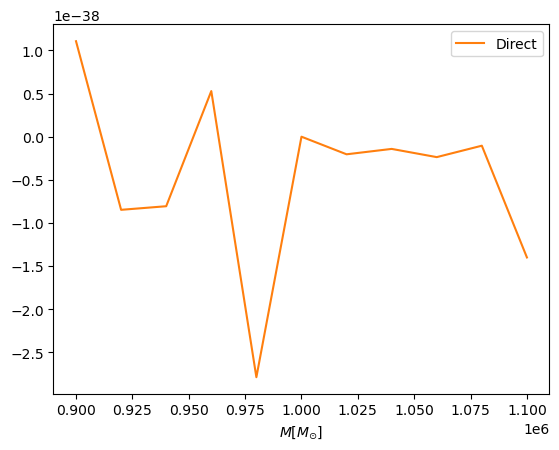

In [27]:
plt.plot(M_grid, direct_logL, color='C1', label='Direct')

plt.xlabel(r'$M [M_{\odot}]$')
plt.legend()
plt.show()

In [28]:
max_idx = np.argmax(direct_logL)
M_best = M_grid[max_idx]
logL_max = direct_logL[max_idx]

print(f"Best M: {M_best:.2e}")

Best M: 9.00e+05


#### Same thing but for mu

In [29]:
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
p0 = 5.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

In [30]:
mu_grid = np.linspace(9.9, 10.1, 11)

direct_logL = -1 * np.ones(len(mu_grid))

# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
for idx, mu in tqdm(enumerate(mu_grid), total=len(mu_grid), desc='M grid'):
    emri_waveform_args_M = [
        M,
        mu,
        a,
        p0,
        e0,
        x0,
        dist,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    
    direct_logL[idx] = log_likelihood(chans, *emri_waveform_args_M)


M grid: 100%|█████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:34<00:00,  3.17s/it]


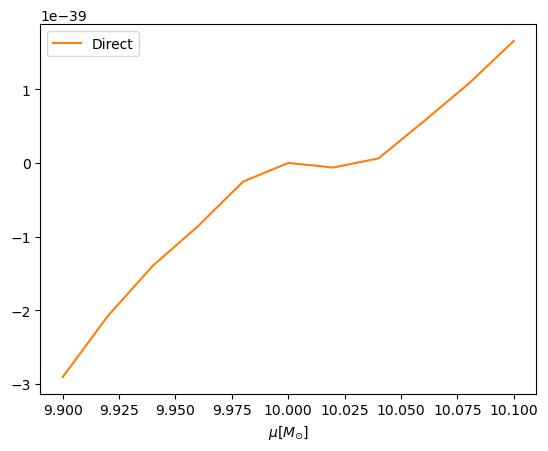

In [31]:
plt.plot(mu_grid, direct_logL, color='C1', label='Direct')

plt.xlabel(r'$\mu [M_{\odot}]$')
plt.legend()
plt.show()

In [32]:
max_idx = np.argmax(direct_logL)
mu_best = mu_grid[max_idx]
logL_max = direct_logL[max_idx]

print(f"Best mu: {mu_best:.2e}")

Best mu: 1.01e+01
